<a href="https://colab.research.google.com/github/poeala/CoderHouse-Data-Science-2/blob/main/Data_StoryTellingAndrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub
import requests
import time


Abstracto: Motivación y Audiencia

Este proyecto tiene como objetivo explorar las características de los Pokémon de la primera generación a partir de un conjunto de datos público, enriquecido con información adicional proveniente de la API oficial de PokeAPI. Se busca analizar patrones, relaciones entre atributos y extraer insights que permitan entender mejor cómo se distribuyen las estadísticas clave como ataque, velocidad, defensa o habilidades especiales entre los diferentes tipos y formas evolutivas.

La motivación principal detrás de este análisis es aprender a aplicar herramientas de ciencia de datos sobre un conjunto de datos divertido, limpio y con alto potencial para la exploración y la predicción. Además, se incorpora el uso de APIs públicas como recurso de enriquecimiento de datos, una habilidad fundamental en proyectos reales de análisis.

La audiencia esperada incluye:

*○ Estudiantes de ciencia de datos: * que estén aprendiendo sobre análisis exploratorio, ingeniería de características y modelado predictivo.
*○ Desarrolladores de videojuegos: * interesados en comprender cómo las estadísticas de personajes pueden influir en el balance del juego.
*○ Fanáticos de Pokémon: * con curiosidad por descubrir qué características hacen que un Pokémon sea más "legendario".

En etapas posteriores, también se busca entrenar modelos de clasificación para predecir si un Pokémon es legendario en base a sus atributos numéricos, analizando el rendimiento de distintos enfoques.

El dataset contiene información de 721 Pokémon —con atributos como stats básicos (HP, Ataque, Defensa, Speed, etc.), tipo primario y secundario, generación y si son legendarios.  https://www.kaggle.com/datasets/abcsds/pokemon

 Preguntas / Hipótesis a responder

A partir del dataset de Pokémon (primera generación ampliada con datos desde PokeAPI), se plantean las siguientes preguntas clave para el análisis:

1. **¿Los Pokémon legendarios tienen realmente mejores stats promedios que los no legendarios?**  
   Se busca evaluar si el atributo "legendario" se corresponde con valores significativamente superiores en estadísticas como ataque, defensa, velocidad o total general de puntos.

2. **¿Qué combinación de tipos (`Type 1` + `Type 2`) es más frecuente y cuál tiene mejores stats promedio?**  
   El objetivo es identificar qué combinaciones de tipos elementales (como Agua + Volador o Planta + Veneno) se repiten con mayor frecuencia y cuáles tienden a tener mejores desempeños generales en términos de sus estadísticas base.

3. **¿Los Pokémon son más lentos mientras más pesados son?**  
   El objetivo es identificar si los Pokémon livianos son más ágiles o rápidos.


Estas preguntas guiarán el análisis exploratorio y las visualizaciones, y permitirán generar insights relevantes sobre el balance, diversidad y poder relativo entre las distintas especies del universo Pokémon.


Carga, limpieza y transformación de los datos

Los datos utilizados en este proyecto provienen de un dataset público de Kaggle que contiene información detallada sobre 721 Pokémon, incluyendo estadísticas base (`HP`, `Ataque`, `Defensa`, `Sp. Atk`, `Sp. Def`, `Speed`), tipo elemental primario y secundario, generación, clasificación como "legendario" o no, entre otros atributos.

Carga de los datos

Los datos fueron importados desde un archivo CSV (`pokemon.csv`) utilizando la biblioteca `pandas`. Además, para enriquecer la información, se incorporaron datos desde la API oficial de Pokémon (`https://pokeapi.co`), tales como:

- **Altura (metros)**  
- **Peso (kg)**  
- **Cantidad de habilidades**  

La API fue consultada dinámicamente utilizando la biblioteca `requests`.

Limpieza

Se realizaron los siguientes pasos de limpieza:

- Estandarización de nombres de columnas para evitar errores (`snake_case`, sin espacios).
- Revisión de valores nulos.
- Conversión de variables categóricas a formato adecuado (`boolean`, `category`).
- Corrección de nombres incompatibles con la API (por ejemplo: `'Nidoran♀' → 'nidoran-f'`).

Transformaciones y columnas creadas

Se crearon nuevas columnas derivadas de los datos originales o enriquecidos:

- `indice_ofensivo`: producto entre `Attack` y `Sp. Atk`  
- `tipo_combinado`: combinación de `Type 1` + `Type 2` para análisis conjunto de tipos  
- `altura_api`, `peso_api`, `n_habilidades_api`: datos provenientes de PokeAPI

Estas transformaciones permiten realizar análisis más ricos sobre rendimiento, características físicas y potencial de combate de los Pokémon, y serán utilizadas en las visualizaciones posteriores para responder las preguntas planteadas.


In [46]:


# Descarga de la última versión del datset
path = kagglehub.dataset_download("abcsds/pokemon")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon


In [47]:
# Se movió el dataset a una carpeta con mayor compatibilidad para ediciones
!cp /kaggle/input/pokemon/Pokemon.csv /content/


In [48]:

df = pd.read_csv("/content/Pokemon.csv")
df.head()


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [49]:


# Cargar el dataset completo
df = pd.read_csv("Pokemon.csv")

# Diccionario para corregir nombres especiales para la API
correcciones = {
    'Mr. Mime': 'mr-mime',
    'Farfetch’d': 'farfetchd',
    'Nidoran♀': 'nidoran-f',
    'Nidoran♂': 'nidoran-m',
    'Flabébé': 'flabebe',
    'Type: Null': 'type-null',
    'Mime Jr.': 'mime-jr',
    'Ho-Oh': 'ho-oh',
    'Porygon-Z': 'porygon-z'
}

# Función para consultar la API y obtener altura, peso y habilidades
def consultar_pokeapi(nombre_pokemon):
    nombre_api = correcciones.get(
        nombre_pokemon,
        nombre_pokemon.lower().replace(" ", "-").replace(".", "").replace("'", "").replace("♀", "-f").replace("♂", "-m")
    )
    url = f'https://pokeapi.co/api/v2/pokemon/{nombre_api}'

    try:
        r = requests.get(url)
        if r.status_code == 200:
            data = r.json()
            altura = data['height'] / 10  # decímetros → metros
            peso = data['weight'] / 10    # hectogramos → kg
            habilidades = len(data['abilities'])
            return pd.Series([altura, peso, habilidades])
        else:
            return pd.Series([None, None, None])
    except:
        return pd.Series([None, None, None])

# Aplicar a todos los Pokémon
df[['altura_api', 'peso_api', 'n_habilidades_api']] = df['Name'].apply(consultar_pokeapi)

# Guardar resultados
df.to_csv("Pokemon_enriquecido.csv", index=False)

# Ver una muestra
df[['Name', 'altura_api', 'peso_api', 'n_habilidades_api']].head()


,Name,altura_api,peso_api,n_habilidades_api
0,Bulbasaur,0.7,6.9,2.0
1,Ivysaur,1.0,13.0,2.0
2,Venusaur,2.0,100.0,2.0
3,VenusaurMega Venusaur,NaN,NaN,NaN
4,Charmander,0.6,8.5,2.0


In [50]:
# Ver principio y fin del csv
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
df


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,altura_api,peso_api,n_habilidades_api
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0.7,6.9,2.0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,1.0,13.0,2.0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,2.0,100.0,2.0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,NaN,NaN,NaN
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,0.6,8.5,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True,0.7,8.8,1.0
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True,NaN,NaN,NaN
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True,NaN,NaN,NaN
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True,NaN,NaN,NaN


In [51]:
#Imprimir nombres de columnas
print(df.columns.tolist())


['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary', 'altura_api', 'peso_api', 'n_habilidades_api']


In [52]:
# Diccionario para renombrar las columnas
df.columns = [
    'id',
    'name',
    'type_1',
    'type_2',
    'total',
    'hp',
    'attack',
    'defense',
    'sp_atk',
    'sp_def',
    'speed',
    'generation',
    'legendary',
    'altura_api',
    'peso_api',
    'n_habilidades_api'
]

# Verificar el cambio
df.head()
df.dtypes

,0
id,int64
name,object
type_1,object
type_2,object
total,int64
hp,int64
attack,int64
defense,int64
sp_atk,int64
sp_def,int64


In [53]:
# Crear columna índice ofensivo: Attack * Sp. Atk
df["indice_ofensivo"] = df["attack"] * df["sp_atk"]


In [54]:
#Tratamiento de nulos
df['type_2'] = df['type_2'].fillna("None")  # o "Sin tipo secundario"




In [55]:
# Eliminar nulos y asegurar tipo de datos
df = df.dropna(subset=['peso_api', 'altura_api', 'n_habilidades_api'])

df['peso_api'] = df['peso_api'].astype(float)
df['altura_api'] = df['altura_api'].astype(float)
df['n_habilidades_api'] = df['n_habilidades_api'].astype(int)


/tmp/ipython-input-3267088764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['peso_api'] = df['peso_api'].astype(float)
/tmp/ipython-input-3267088764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['altura_api'] = df['altura_api'].astype(float)
/tmp/ipython-input-3267088764.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [56]:
# Ver si quedó algún nulo
df.isnull().sum()
#Ver cuantas filas y columnas quedaron
df.shape


(704, 17)

In [58]:
df.dtypes

,0
id,int64
name,object
type_1,object
type_2,object
total,int64
hp,int64
attack,int64
defense,int64
sp_atk,int64
sp_def,int64


/tmp/ipython-input-178119975.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


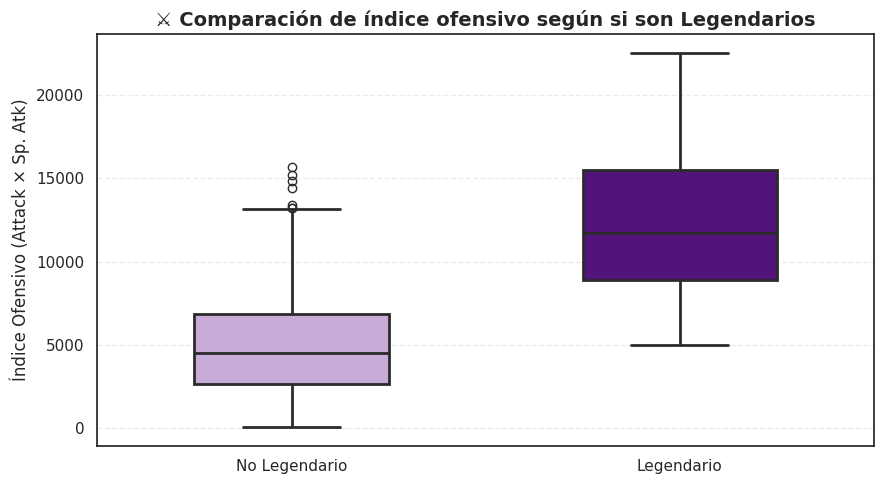

In [60]:


colores = {'False': '#CBA3E2', 'True': '#55038C'}

plt.figure(figsize=(9, 5))
sns.boxplot(
    data=df,
    x='legendary',
    y='indice_ofensivo',
    palette=colores,
    width=0.5,
    linewidth=2
)

plt.title("⚔️ Comparación de índice ofensivo según si son Legendarios", fontsize=14, fontweight='bold')
plt.xlabel("")
plt.ylabel("Índice Ofensivo (Attack × Sp. Atk)", fontsize=12)
plt.xticks([0, 1], ['No Legendario', 'Legendario'], fontsize=11)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1010950472.py:28: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


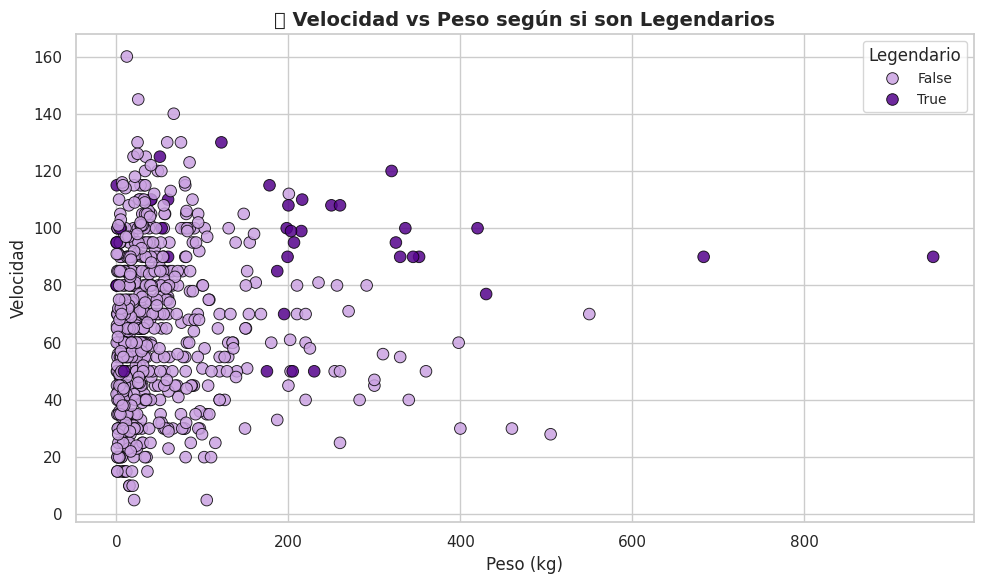

,peso_api,altura_api,speed,total
peso_api,1.000000,0.637686,0.103628,0.543320
altura_api,0.637686,1.000000,0.221511,0.529319
speed,0.103628,0.221511,1.000000,0.537483
total,0.543320,0.529319,0.537483,1.000000


In [69]:
# Paleta violeta clara para no legendarios, violeta fuerte para legendarios
colores = {False: '#CBA3E2', True: '#55038C'}

# Crear figura
plt.figure(figsize=(10, 6))

# Scatterplot
sns.scatterplot(
    data=df,
    x='peso_api',
    y='speed',
    hue='legendary',
    palette=colores,
    edgecolor='black',
    s=70,
    alpha=0.85
)

# Títulos y etiquetas
plt.title("💨 Velocidad vs Peso según si son Legendarios", fontsize=14, fontweight='bold')
plt.xlabel("Peso (kg)", fontsize=12)
plt.ylabel("Velocidad", fontsize=12)

# Leyenda
plt.legend(title="Legendario", title_fontsize=12, fontsize=10, loc="upper right")

plt.grid(True)
plt.tight_layout()
plt.show()

df[['peso_api', 'altura_api', 'speed', 'total']].corr()

El gráfico de dispersión muestra la relación entre el peso y la velocidad de los Pokémon, diferenciando si son legendarios o no.

**Conclusiones:**
- La **correlación entre peso y velocidad es baja (r ≈ 0.10)**, lo que indica que el peso **no es un buen predictor** de la velocidad.
- Pokémon muy livianos presentan una amplia variabilidad en velocidad.
- Existen Pokémon muy pesados con velocidades altas, especialmente entre los legendarios, lo cual contradice la creencia de que los Pokémon pesados son necesariamente lentos.
- El patrón sugiere que la **velocidad está más influenciada por otros atributos** del juego (tipo, rol, generación) y no tanto por características físicas como el peso.

/tmp/ipython-input-2279756386.py:24: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


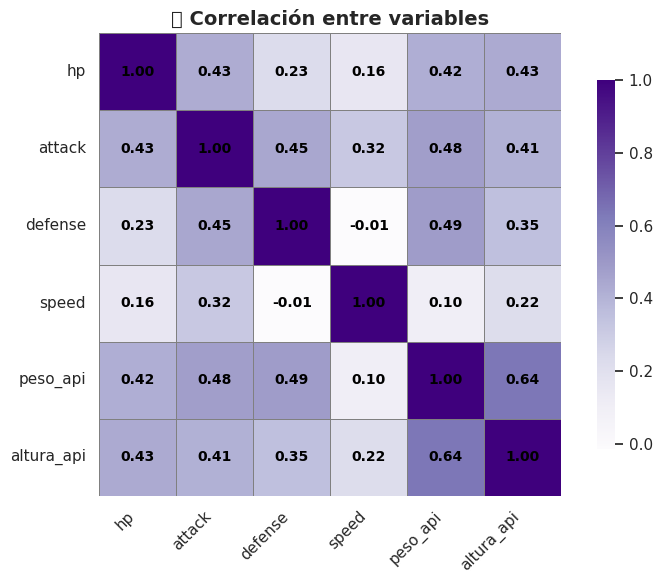

In [37]:
# Matriz de correlación
corr = df[['hp', 'attack', 'defense', 'speed', 'peso_api', 'altura_api']].corr()

# Tamaño y estilo
plt.figure(figsize=(8, 6))
sns.set(style="white")

# Heatmap con paleta violeta personalizada
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Purples",
    square=True,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": .8},
    annot_kws={"size": 10, "weight": "bold", "color": "black"}
)

plt.title("🔍 Correlación entre variables", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Correlación entre variables

- Existe una **fuerte correlación positiva entre peso y altura** (`r = 0.64`), como era esperable.
- El peso también se asocia moderadamente con **Attack (0.48)**, **Defense (0.49)** y **HP (0.42)**, lo que indica que Pokémon más pesados tienden a ser más resistentes y fuertes físicamente.
- **Speed tiene muy baja correlación** con el resto de las variables, especialmente con peso (`r = 0.10`), desmintiendo la idea de que los Pokémon más pesados necesariamente son más lentos.
- Las estadísticas ofensivas (`Attack`, `Sp. Atk`) y defensivas están parcialmente relacionadas entre sí.

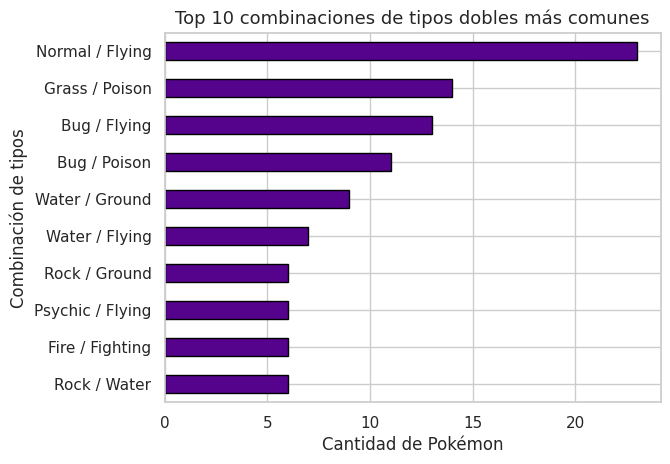

tipo_combinado
Normal / Flying      23
Grass / Poison       14
Bug / Flying         13
Bug / Poison         11
Water / Ground        9
                     ..
Fighting / Dark       1
Poison / Dragon       1
Fighting / Flying     1
Electric / Fairy      1
Fire / Water          1
Name: count, Length: 123, dtype: int64


In [63]:
# Filtrar Pokémon que tienen tipo secundario (es decir, no nulo)
df_dobles = df[df['type_2'] != "None"].copy()

# Crear la columna combinada solo para los que tienen ambos tipos
df_dobles['tipo_combinado'] = df_dobles['type_1'] + ' / ' + df_dobles['type_2']

# Contar combinaciones más comunes
top_combos_dobles = df_dobles['tipo_combinado'].value_counts().head(10)

# Graficar
top_combos_dobles.plot(kind='barh', color='#55038C', edgecolor='black')
plt.title("Top 10 combinaciones de tipos dobles más comunes", fontsize=13)
plt.xlabel("Cantidad de Pokémon")
plt.ylabel("Combinación de tipos")
plt.gca().invert_yaxis()
plt.show()
tipo_combinado_counts = df_dobles['tipo_combinado'].value_counts()
print(tipo_combinado_counts)

El gráfico muestra las combinaciones de tipos elementales más frecuentes entre los Pokémon que tienen **dos tipos** (excluyendo aquellos con solo un tipo).

- `Normal / Flying` es la combinación más común, representando a muchas especies de aves (como Pidgey, Swellow o Staraptor).
- Le siguen combinaciones comunes en generaciones tempranas como `Grass / Poison` y `Bug / Poison`, típicas de Pokémon tipo planta o insecto con habilidades venenosas.
- Otras combinaciones como `Water / Flying` y `Rock / Ground` también son frecuentes y reflejan líneas evolutivas consistentes dentro del juego.

                      hp  attack  defense  sp_atk  sp_def  speed  total
tipo_combinado                                                         
Dragon / Fire      100.0   120.0    100.0   150.0   120.0   90.0  680.0
Dragon / Electric  100.0   150.0    120.0   120.0   100.0   90.0  680.0
Steel / Dragon     100.0   120.0    120.0   150.0   100.0   90.0  680.0
Dragon / Ice       125.0   130.0     90.0   130.0    90.0   95.0  660.0
Water / Dragon      82.5   107.5     97.5   122.5   107.5   92.5  610.0
Dragon / Psychic    80.0    85.0     85.0   120.0   120.0  110.0  600.0
Fire / Water        80.0   110.0    120.0   130.0    90.0   70.0  600.0
Psychic / Fire     100.0   100.0    100.0   100.0   100.0  100.0  600.0
Rock / Dark        100.0   134.0    110.0    95.0   100.0   61.0  600.0
Fire / Steel        91.0    90.0    106.0   130.0   106.0   77.0  600.0


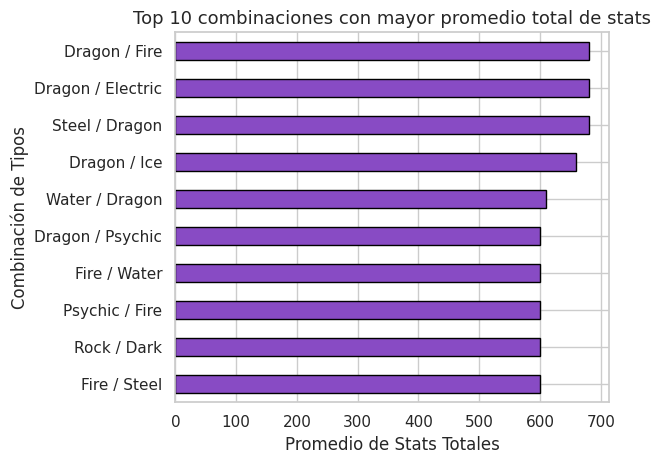

In [68]:
# Calcular stats promedio por combinación
promedios_stats = df_dobles.groupby('tipo_combinado')[['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed', 'total']].mean()

# Ordenar por stat total promedio
mejores_combinaciones = promedios_stats.sort_values(by='total', ascending=False).head(10)
print(mejores_combinaciones)
mejores_combinaciones['total'].plot(kind='barh', color='#884BC4', edgecolor='black')
plt.title("Top 10 combinaciones con mayor promedio total de stats", fontsize=13)
plt.xlabel("Promedio de Stats Totales")
plt.ylabel("Combinación de Tipos")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Las combinaciones con mejores stats promedio están encabezadas por:

Dragon / Fire

Dragon / Electric

Steel / Dragon

Dragon / Ice

Estas combinaciones tienen un promedio total de stats cercano a 680, lo que es muy superior al promedio general de Pokémon no legendarios (que ronda los 400–500 en muchos casos).

Los Pokémon con combinaciones que incluyen el tipo Dragon (ya sea con Fire, Electric, Steel, Ice, etc.) tienden a tener los mejores valores promedio de stats totales.

Esto sugiere que el tipo Dragon está altamente asociado con Pokémon poderosos, en especial en combinaciones ofensivas (Sp. Atk y Attack muy altos).

Estas combinaciones probablemente incluyan muchos Pokémon legendarios, lo que podría influir en su alto promedio de stats.

/tmp/ipython-input-1487890197.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='generation', y='total', palette='Purples_r', ci='sd')
/tmp/ipython-input-1487890197.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='generation', y='total', palette='Purples_r', ci='sd')


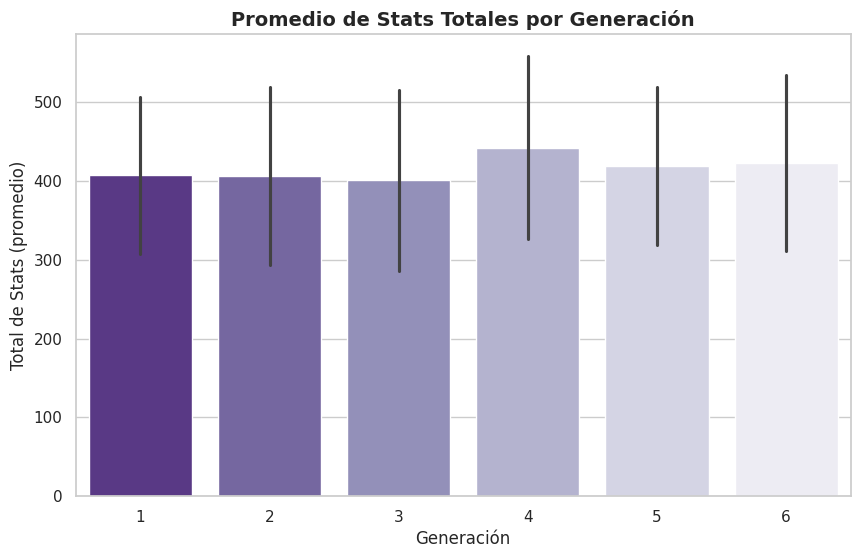

In [35]:
# Estilo
sns.set(style="whitegrid")

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='generation', y='total', palette='Purples_r', ci='sd')
color = "#884bc4"
# Títulos y etiquetas
plt.title("Promedio de Stats Totales por Generación", fontsize=14, fontweight='bold')
plt.xlabel("Generación", fontsize=12)
plt.ylabel("Total de Stats (promedio)", fontsize=12)
plt.xticks(ticks=range(0, 6), labels=["1", "2", "3", "4", "5", "6"])
plt.show()



Promedio de Stats Totales por Generación

Se observa que el promedio de stats totales de los Pokémon se mantiene relativamente estable entre generaciones, con valores entre 400 y 450.
La Generación 4 destaca con un promedio más alto, lo cual podría deberse a la introducción de nuevas evoluciones de Pokémon previos y un aumento en la cantidad de legendarios.
Esta información es útil para analizar el balance del juego a lo largo del tiempo, y podría ser clave si se entrena un modelo predictivo sensible a la generación.

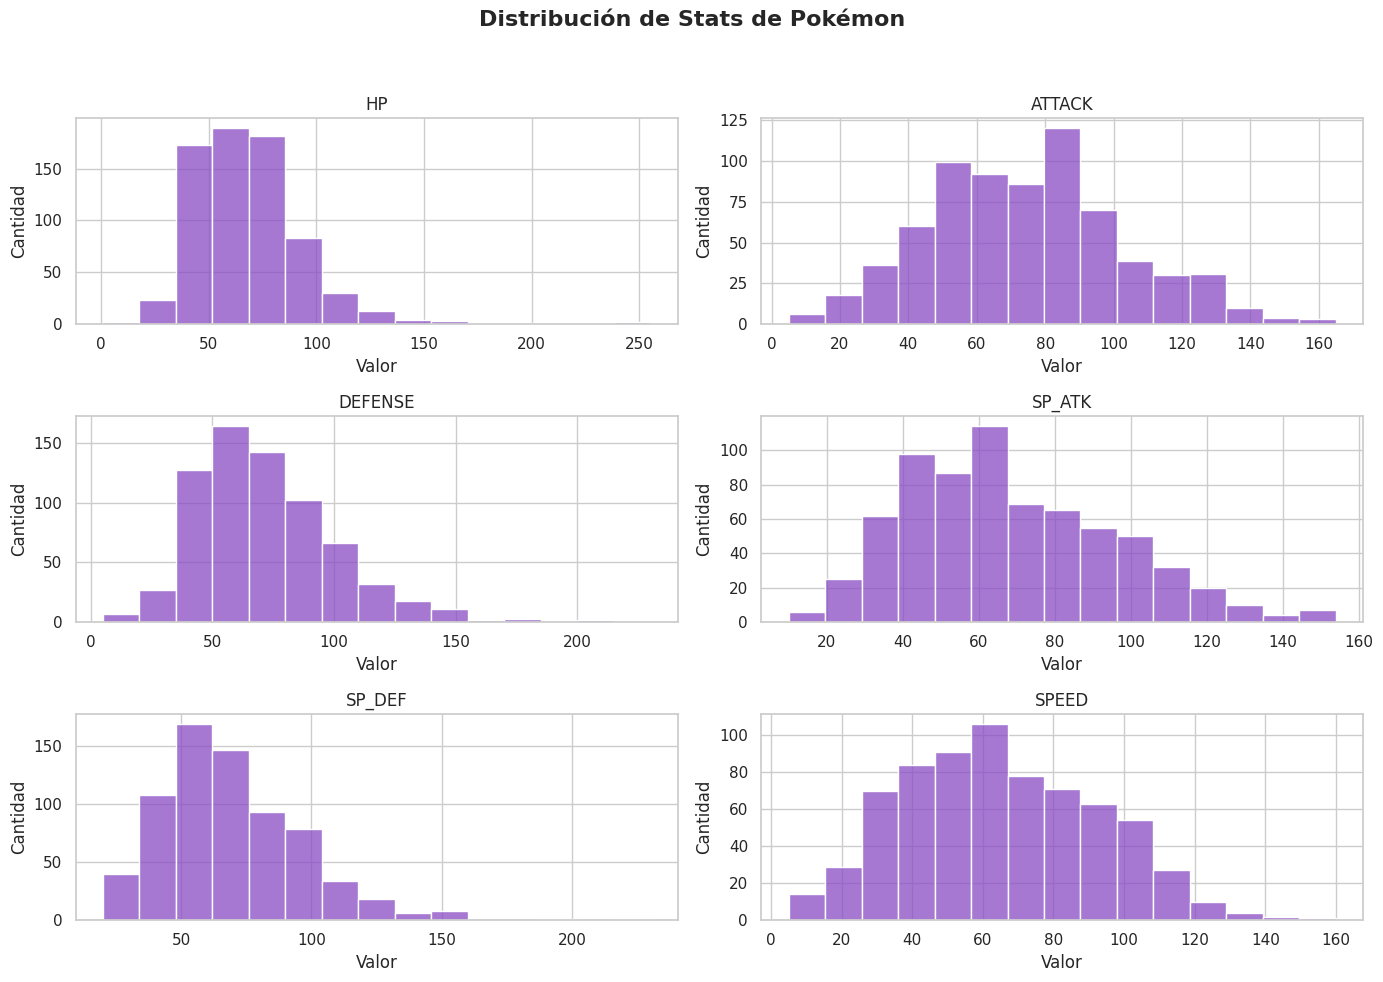

In [61]:
# Estilo de Seaborn
sns.set_style("whitegrid")

# Variables a graficar (agregamos ataque y defensa especial)
stats = ['hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']

# Crear figura con 3 filas y 2 columnas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Distribución de Stats de Pokémon", fontsize=16, fontweight='bold')

# Color personalizado
color = "#884bc4"

# Histograma para cada stat
for ax, stat in zip(axes.flatten(), stats):
    sns.histplot(df[stat], bins=15, kde=False, color=color, ax=ax)
    ax.set_title(stat.upper(), fontsize=12)
    ax.set_xlabel("Valor")
    ax.set_ylabel("Cantidad")

# Ajuste de diseño
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Distribución de Stats

Los histogramas muestran cómo se distribuyen las principales estadísticas de los Pokémon (HP, Ataque, Defensa y Velocidad, Ataque especial y Defensa especial).  
Se observa que:

La mayoría de los stats tienen distribuciones concentradas en rangos medios (50–80), con algunos valores extremos hacia arriba, probablemente correspondientes a Pokémon legendarios o de élite.

Ataque, Ataque Especial y Velocidad tienen distribuciones algo más extendidas, sugiriendo mayor variabilidad entre especies.

HP y Defensa(s) muestran sesgo positivo, indicando muchos Pokémon con valores bajos a medios, y pocos con valores muy altos.

Estos patrones sugieren que los Pokémon están diseñados con un balance en los valores intermedios, y solo unos pocos presentan stats extremos.

Conclusiones finales:

Los Pokémon legendarios presentan, en promedio, valores significativamente más altos en todos los stats principales (ataque, velocidad, etc.), lo que valida la etiqueta de "legendario".

Las combinaciones de tipo más comunes fueron Normal / Flying y Bug / Poison, lo que refleja tendencias en el diseño de Pokémon de generaciones iniciales.

No se encontró una fuerte relación entre peso y velocidad, ya que algunos Pokémon muy pesados también tienen velocidad alta, posiblemente por diseño del juego.

El uso de la PokeAPI permitió enriquecer los datos de manera dinámica, simulando una práctica real en proyectos de ciencia de datos.